<a href="https://colab.research.google.com/github/alexhenriquepineda/Previsao-Notas-ENEM/blob/main/TCC_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
zipfile.ZipFile('/content/drive/MyDrive/TCC/datasets/enem.zip', 'r').extractall('/content/drive/MyDrive/TCC/datasets')

**0.0 IMPORTS**

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**0.1 HELPER FUNCTION**

In [60]:
from IPython.core.display  import HTML
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    fonte: https://www.kaggle.com/valleyzw/ubiquant-lgbm-baseline  
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm([x for x in df.columns if 'NU_NOTA_' not in x]):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**1.0 LOADING DATA**

In [8]:
data_raw = pd.read_csv('/content/drive/MyDrive/TCC/datasets/train.csv')

In [9]:
data = reduce_mem_usage(data_raw)

Memory usage of dataframe is 2981.62 MB


100%|██████████| 113/113 [00:58<00:00,  1.93it/s]

Memory usage after optimization is: 732.86 MB
Decreased by 75.4%


**2.0 DATA DESCRIPTION**

In [10]:
df_train = data.copy()

In [11]:
colunas_dados_participante = ['NU_INSCRICAO','CO_MUNICIPIO_RESIDENCIA','NO_MUNICIPIO_RESIDENCIA','CO_UF_RESIDENCIA','SG_UF_RESIDENCIA',
                              'NU_IDADE','TP_SEXO','TP_ESTADO_CIVIL','TP_COR_RACA','TP_NACIONALIDADE','CO_MUNICIPIO_NASCIMENTO',
                              'NO_MUNICIPIO_NASCIMENTO','CO_UF_NASCIMENTO','SG_UF_NASCIMENTO','TP_ST_CONCLUSAO','TP_ANO_CONCLUIU',
                              'TP_ESCOLA','TP_ENSINO','IN_TREINEIRO']

#Features com o código da região do estado
df_train['CO_REGIAO_RESIDENCIA'] = df_train['CO_MUNICIPIO_RESIDENCIA'].astype(str).str[:3]

#Age Groups
# Criar grupos de partipantes conforme a faixa de idade
group = (0, 15, 18, 23, 36, 60, 120)
cats = ['ADOLESCENTE','ADOLESCENTE_2', 'JOVEM','JOVEM_2', 'ADULTO', 'IDOSO']
#df_train["NO_IDADE_GROUP"] = pd.cut(df_train.NU_IDADE, group, labels=cats)

colunas_dados_participante = list(set(colunas_dados_participante) - (set(colunas_dados_participante) - set(df_train.columns) ) )

# ==============================================================================

colunas_dados_escola = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC','CO_UF_ESC','SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC',
                        'TP_LOCALIZACAO_ESC','TP_SIT_FUNC_ESC']

colunas_dados_escola = list(set(colunas_dados_escola) - (set(colunas_dados_escola) - set(df_train.columns) ) )

# ==============================================================================

colunas_atend_especial = ['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA','IN_SURDO_CEGUEIRA',
                          'IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL','IN_DEFICIT_ATENCAO','IN_DISLEXIA',
                          'IN_DISCALCULIA','IN_AUTISMO','IN_VISAO_MONOCULAR','IN_OUTRA_DEF']

colunas_atend_especial = list(set(colunas_atend_especial) - (set(colunas_atend_especial) - set(df_train.columns) ) )

#df_train["IN_ATEND_ESPECIAL"] = df_train[colunas_atend_especial].max(axis=1)

# ==============================================================================

colunas_atend_especifico = ['IN_GESTANTE','IN_LACTANTE','IN_IDOSO','IN_ESTUDA_CLASSE_HOSPITALAR']
colunas_atend_especifico = list(set(colunas_atend_especifico) - (set(colunas_atend_especifico) - set(df_train.columns) ) )

#df_train["IN_ATEND_ESPECIFICO"] = df_train[colunas_atend_especifico].max(axis=1)

# ==============================================================================

colunas_recurso_especial = ['IN_SEM_RECURSO','IN_BRAILLE','IN_AMPLIADA_24','IN_AMPLIADA_18','IN_LEDOR','IN_ACESSO',
                            'IN_TRANSCRICAO','IN_LIBRAS','IN_TEMPO_ADICIONAL','IN_LEITURA_LABIAL','IN_MESA_CADEIRA_RODAS',
                            'IN_MESA_CADEIRA_SEPARADA','IN_APOIO_PERNA','IN_GUIA_INTERPRETE','IN_COMPUTADOR','IN_CADEIRA_ESPECIAL',
                            'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA','IN_PROVA_DEITADO','IN_MOBILIARIO_OBESO','IN_LAMINA_OVERLAY',
                            'IN_PROTETOR_AURICULAR','IN_MEDIDOR_GLICOSE','IN_MAQUINA_BRAILE','IN_SOROBAN','IN_MARCA_PASSO','IN_SONDA',
                            'IN_MEDICAMENTOS','IN_SALA_INDIVIDUAL','IN_SALA_ESPECIAL','IN_SALA_ACOMPANHANTE','IN_MOBILIARIO_ESPECIFICO',
                            'IN_MATERIAL_ESPECIFICO','IN_NOME_SOCIAL']

colunas_recurso_especial = list(set(colunas_recurso_especial) - (set(colunas_recurso_especial) - set(df_train.columns) ) )

#df_train["IN_RECURSO_ESPECIAL"] = df_train[colunas_recurso_especial].max(axis=1)
#df_train["IN_RECURSO_ESPECIAL"] = df_train["IN_SEM_RECURSO"]

# ==============================================================================

colunas_local_prova = ['CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA','CO_UF_PROVA','SG_UF_PROVA']

colunas_local_prova = list(set(colunas_local_prova) - (set(colunas_local_prova) - set(df_train.columns) ) )

# ==============================================================================

colunas_prova_objetiva = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                          'NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT','TP_LINGUA']

colunas_prova_objetiva = list(set(colunas_prova_objetiva) - (set(colunas_prova_objetiva) - set(df_train.columns) ) )

# ==============================================================================

colunas_prova_redacao = ['TP_STATUS_REDACAO','NU_NOTA_REDACAO']

colunas_prova_redacao = list(set(colunas_prova_redacao) - (set(colunas_prova_redacao) - set(df_train.columns) ) )

# ==============================================================================

colunas_socio_economico = ['Q001','Q002','Q003','Q004','Q005','Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013',
                           'Q014','Q015','Q016','Q017','Q018','Q019','Q020','Q021','Q022','Q023','Q024','Q025'
]

colunas_socio_economico = list(set(colunas_socio_economico) - (set(colunas_socio_economico) - set(df_train.columns) ) )

**2.1 TAMANHO DA BASE**

In [12]:
df_train.shape

(3311925, 119)

**2.2 CHECK NA**

In [28]:
def getMissing(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.sort_values(by='Total', ascending=False, inplace=True)
    print(missing_data[missing_data['Total'] > 0])

In [29]:
getMissing(df_train)

                           Total    Percent
CO_MUNICIPIO_ESC         2566547  77.494116
TP_SIT_FUNC_ESC          2566547  77.494116
TP_LOCALIZACAO_ESC       2566547  77.494116
TP_DEPENDENCIA_ADM_ESC   2566547  77.494116
SG_UF_ESC                2566547  77.494116
CO_UF_ESC                2566547  77.494116
NO_MUNICIPIO_ESC         2566547  77.494116
CO_ESCOLA                2566547  77.494116
TP_ENSINO                1441571  43.526680
NU_NOTA_MT                900794  27.198502
NU_NOTA_CN                900794  27.198502
TP_STATUS_REDACAO         762324  23.017550
NU_NOTA_REDACAO           762324  23.017550
NU_NOTA_LC                762323  23.017520
NU_NOTA_CH                762323  23.017520
CO_UF_NASCIMENTO           94562   2.855198
CO_MUNICIPIO_NASCIMENTO    94562   2.855198
SG_UF_NASCIMENTO           94562   2.855198
NO_MUNICIPIO_NASCIMENTO    94562   2.855198
NU_IDADE                      34   0.001027


In [30]:
df_train[colunas_prova_objetiva].isna().sum()

TP_PRESENCA_CH         0
TP_LINGUA              0
TP_PRESENCA_LC         0
NU_NOTA_CH        762323
NU_NOTA_LC        762323
TP_PRESENCA_MT         0
TP_PRESENCA_CN         0
NU_NOTA_MT        900794
NU_NOTA_CN        900794
dtype: int64

**3.0 DATA FILTERING**

In [31]:
df1 = df_train.copy()

**3.1 EXCLUIR ALUNOS QUE NÃO FIZERAM A PROVA OU FORAM DESCLASSIFICADOS**

In [32]:
df1 = df1.loc[(df1['TP_PRESENCA_LC'] == 1) & 
                        (df1['TP_PRESENCA_CH'] == 1) & 
                        (df1['TP_PRESENCA_MT'] == 1) & 
                        (df1['TP_PRESENCA_CN'] == 1) &
                        (df1['TP_STATUS_REDACAO'] == 1) ]

In [33]:
getMissing(df1)

                           Total    Percent
CO_MUNICIPIO_ESC         1738486  74.391778
NO_MUNICIPIO_ESC         1738486  74.391778
TP_LOCALIZACAO_ESC       1738486  74.391778
CO_ESCOLA                1738486  74.391778
TP_SIT_FUNC_ESC          1738486  74.391778
CO_UF_ESC                1738486  74.391778
TP_DEPENDENCIA_ADM_ESC   1738486  74.391778
SG_UF_ESC                1738486  74.391778
TP_ENSINO                 995451  42.596472
NO_MUNICIPIO_NASCIMENTO    66402   2.841417
CO_UF_NASCIMENTO           66402   2.841417
SG_UF_NASCIMENTO           66402   2.841417
CO_MUNICIPIO_NASCIMENTO    66402   2.841417
NU_IDADE                      29   0.001241


In [34]:
df1[colunas_prova_objetiva].isna().sum()

TP_PRESENCA_CH    0
TP_LINGUA         0
TP_PRESENCA_LC    0
NU_NOTA_CH        0
NU_NOTA_LC        0
TP_PRESENCA_MT    0
TP_PRESENCA_CN    0
NU_NOTA_MT        0
NU_NOTA_CN        0
dtype: int64

**3.2 FILTRANDO ALUNOS PELA IDADE PARA REMOVER ALGUNS OUTLIERS**

In [111]:
df1 = df1[(df1['NU_IDADE'] >= 14) & (df1['NU_IDADE'] <= 70)]

**4.0 FEATURE ENGINEERING**

In [112]:
df2 = df1.copy()

**4.1 CRIANDO VARIÁVEL MÉDIA DAS NOTAS**

In [113]:
df2['MEDIA_NOTAS'] = (df2['NU_NOTA_CH'] + df2['NU_NOTA_LC'] + df2['NU_NOTA_MT'] + df2['NU_NOTA_CN'] + df2['NU_NOTA_REDACAO']) / 5

**4.2 CRIANDO VARIÁVEL DE REGIÃO**

In [114]:
norte = ['RO', 'PA', 'AM', 'AC', 'RR', 'TO', 'AP']
sudeste = ['MG', 'SP', 'RJ', 'ES']
nordeste = ['PB', 'CE', 'PI', 'MA', 'RN', 'BA', 'AL', 'PE', 'SE'] 
sul = ['PR', 'RS', 'SC']
centrooeste = ['MS', 'DF', 'GO', 'MT']
df2['REGIAO'] = df2['SG_UF_RESIDENCIA'].apply(lambda x: 'NORTE' if x in(norte) else 'SUDESTE' if x in(sudeste) else 'NORDESTE' if x in(nordeste) else 'SUL' if x in(sul) else 'CENTRO-OESTE' if x in(centrooeste) else  0)

**5.0 EXPLORE DATA ANALYSIS**

In [115]:
df3 = df2.copy()

**5.1 ESTATÍSTICA DESCRITIVA**

In [116]:
num_attributes = df3[colunas_prova_objetiva]
cat_attributes = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

Skew: mostra a deformação da sua distribuição em relação a normal

**Skew positiva:** deformação para a esquerda

**Skew negativa:** deformação para a direita

Kurtosis: mostra o quão os dados estão concentrados.

Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande

Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

In [117]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,TP_PRESENCA_CH,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
1,TP_LINGUA,0.0,1.0,1.0,0.500354,1.0,0.500000,-0.001415,-2.000000
2,TP_PRESENCA_LC,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
3,NU_NOTA_CH,0.0,835.1,835.1,511.973954,515.7,80.321952,-0.174244,0.265252
4,NU_NOTA_LC,0.0,801.7,801.7,524.325559,529.4,61.653610,-0.579255,1.302209
5,TP_PRESENCA_MT,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
6,TP_PRESENCA_CN,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
7,NU_NOTA_MT,0.0,985.5,985.5,525.267284,503.9,109.257430,0.673072,-0.104045
8,NU_NOTA_CN,0.0,860.9,860.9,479.430877,472.4,76.005602,0.348700,-0.289266


**5.2 DADOS DOS PARTICIPANTES**

**5.2.1 Estados mais desenvolvidos têm notas maiores que estados menos desenvolvidos**

In [118]:
estados_media = df3[['SG_UF_RESIDENCIA', 'MEDIA_NOTAS', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_CN']].groupby('SG_UF_RESIDENCIA').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()

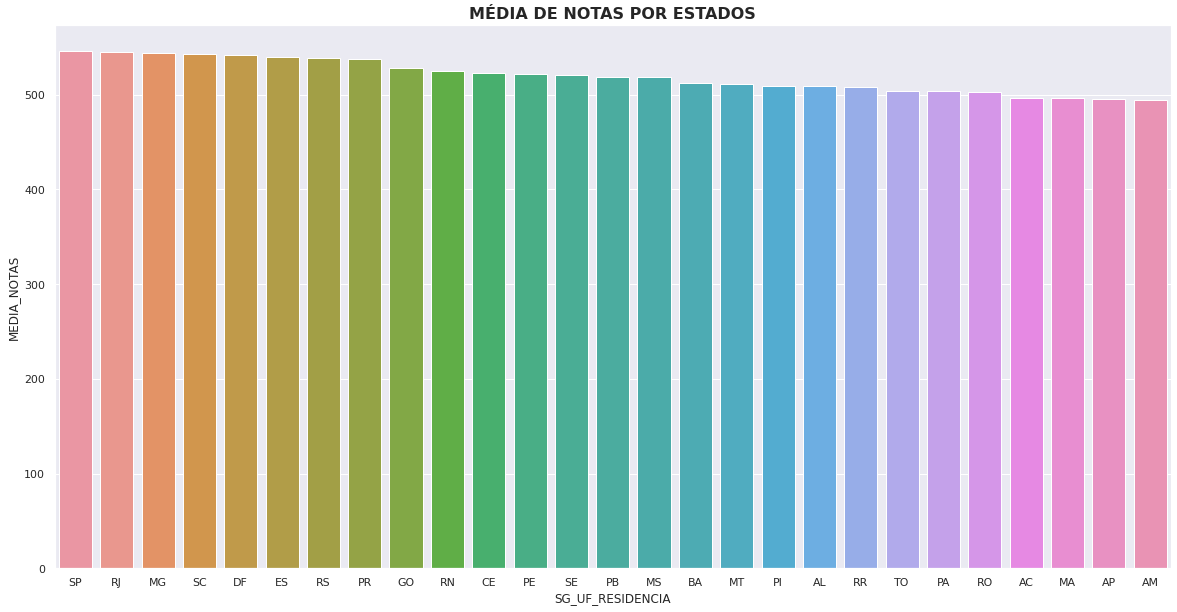

In [119]:
sns.barplot(x='SG_UF_RESIDENCIA', y='MEDIA_NOTAS', data=estados_media, order=estados_media['SG_UF_RESIDENCIA']);
plt.title('MÉDIA DE NOTAS POR ESTADOS', fontsize=16, fontweight='bold');

**5.2.2 A REGIÃO SUDESTE TEM AS MAIORES NOTAS**

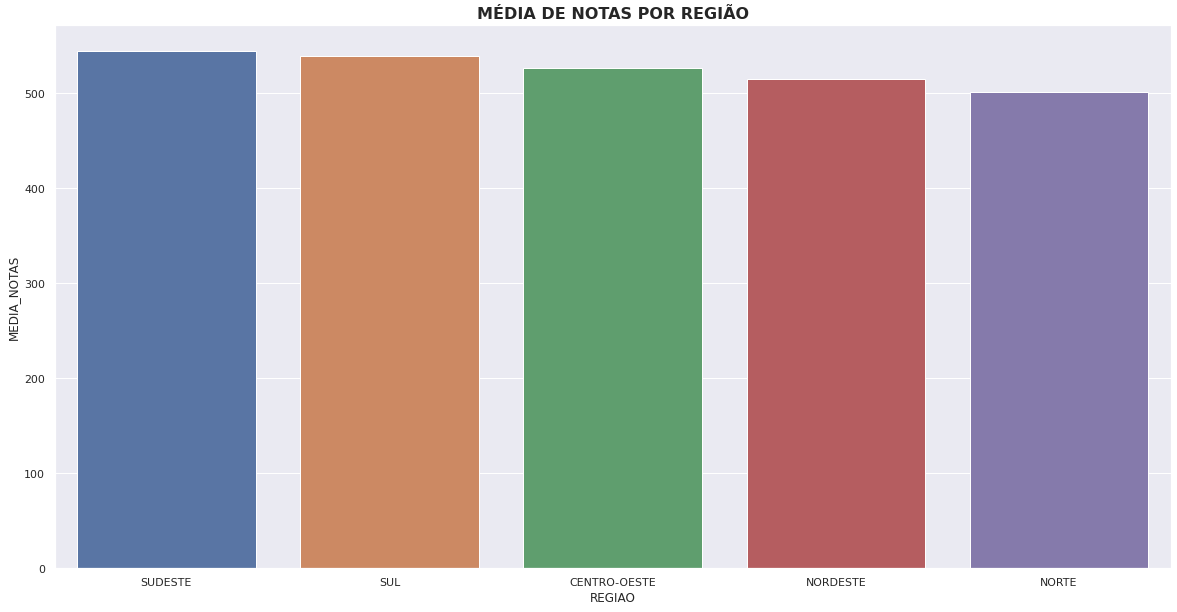

In [120]:
regiao = df3[['REGIAO', 'MEDIA_NOTAS', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_CN']].groupby('REGIAO').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()
sns.barplot(x='REGIAO', y='MEDIA_NOTAS', data=regiao, order=regiao['REGIAO']);
plt.title('MÉDIA DE NOTAS POR REGIÃO', fontsize=16, fontweight='bold');

**5.2.3 JOVENS DE 17 A 22 ANOS TEM AS MAIORES NOTAS**

In [121]:
aux = df3[['NU_IDADE', 'MEDIA_NOTAS']].groupby('NU_IDADE').mean().reset_index()
bins = list(np.arange(0, 100, 2))
aux['IDADE_BINNED'] = pd.cut( aux['NU_IDADE'], bins=bins)
aux.sort_values('MEDIA_NOTAS', ascending=False, inplace=True)

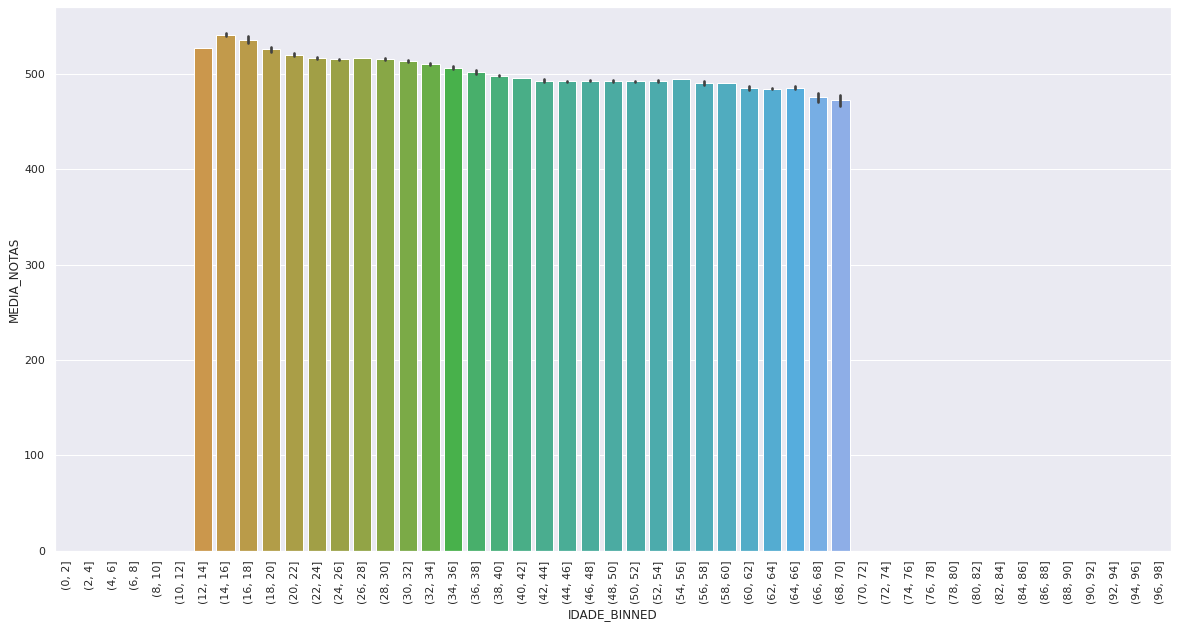

In [122]:
sns.barplot(x='IDADE_BINNED', y='MEDIA_NOTAS', data=aux);
plt.xticks(rotation=90);

**5.2.4 MULHERES TEM NOTAS MAIS ALTAS QUE HOMENS**

**HIPÓTESE FALSA:** em média os homens tem notas mais altas que as mulheres

  TP_SEXO  MEDIA_NOTAS
0       F   521.992881
1       M   535.779884


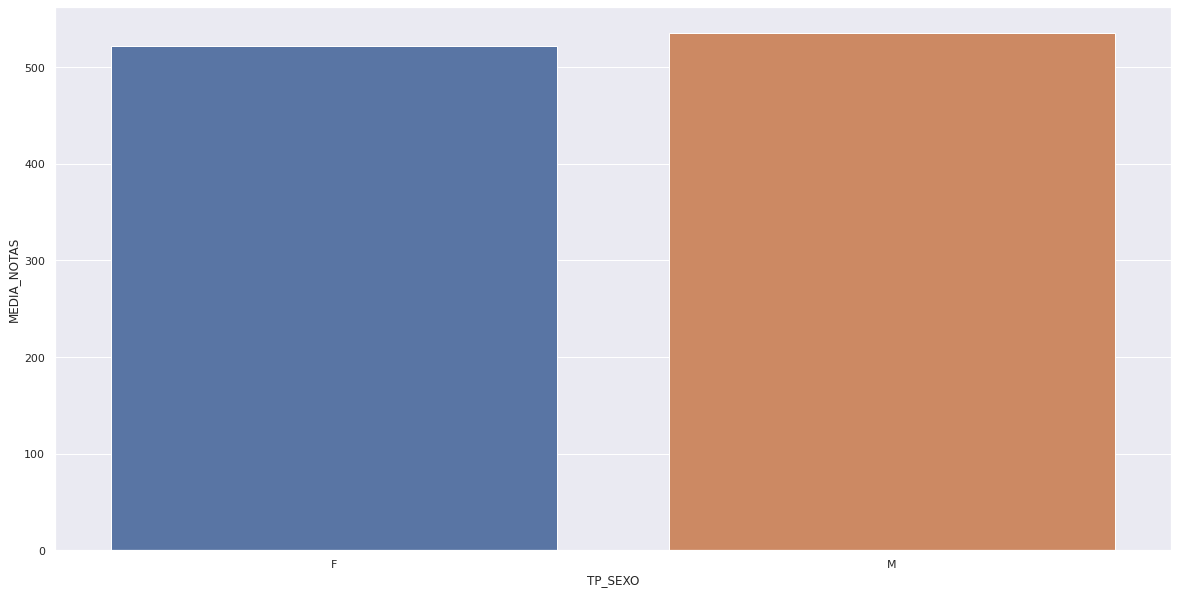

In [135]:
aux = df3[['TP_SEXO', 'MEDIA_NOTAS']].groupby('TP_SEXO').mean().reset_index()
print(aux)
ax = sns.barplot(x='TP_SEXO', y='MEDIA_NOTAS', data=aux);

**5.2.5 Devido ao racismo estrutural, os brancos têm maiores notas**

   TP_COR_RACA  MEDIA_NOTAS
0            1       546.50
1            0       525.86
2            4       513.84
3            3       503.46
4            2       500.70
5            5       476.42


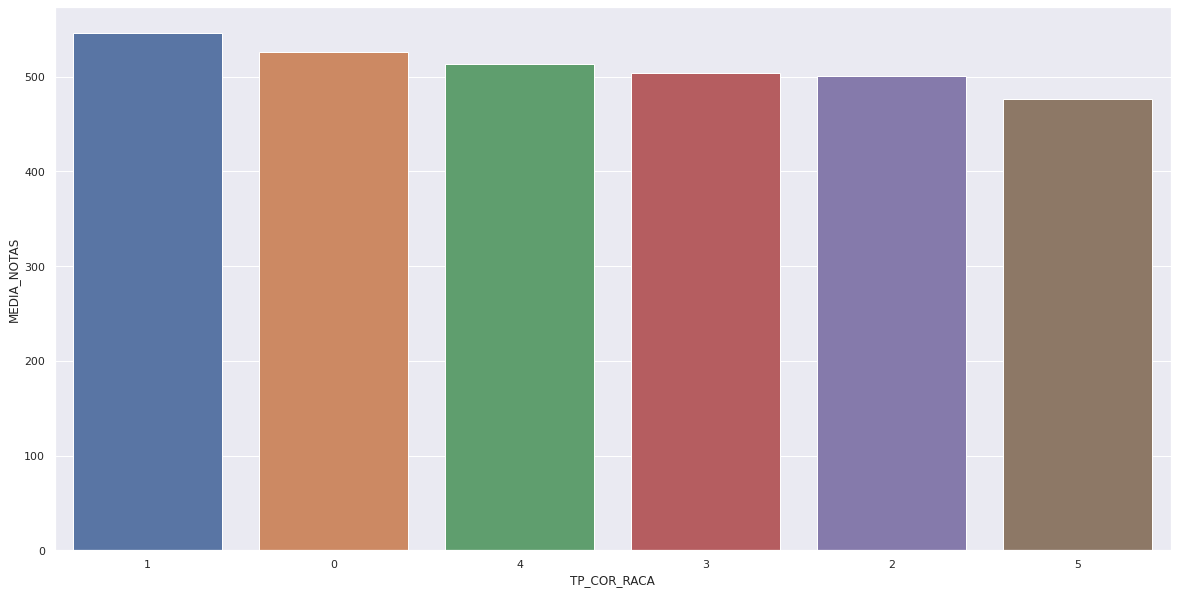

In [140]:
aux = df3[['TP_COR_RACA', 'MEDIA_NOTAS']].groupby('TP_COR_RACA').median().sort_values('MEDIA_NOTAS', ascending=False).reset_index()
print(aux)
ax = sns.barplot(x='TP_COR_RACA', y='MEDIA_NOTAS', data=aux, order=aux['TP_COR_RACA']);
# 0 = NÃO DECLARADO
# 1 = BRANCA
# 2 = PRETA
# 3 = PARDA
# 4 = AMARELA
# 5 = INDÍGENA

In [141]:
df3['TP_COR_RACA'].value_counts()

3    1063586
1     875544
2     284819
4      53643
0      45835
5      13104
Name: TP_COR_RACA, dtype: int64

**5.2.6 Quanto mais distante a formação do ensino médio, menor a nota**

    TP_ANO_CONCLUIU  MEDIA_NOTAS
0                 1   531.836450
1                 3   530.886655
2                 2   530.410445
3                 0   527.999493
4                 4   527.156973
5                 5   525.867035
6                 6   524.392814
7                 8   524.253793
8                 7   523.532945
9                11   522.093547
10               10   520.792793
11                9   520.021771
12               12   518.097503
13               13   517.705492


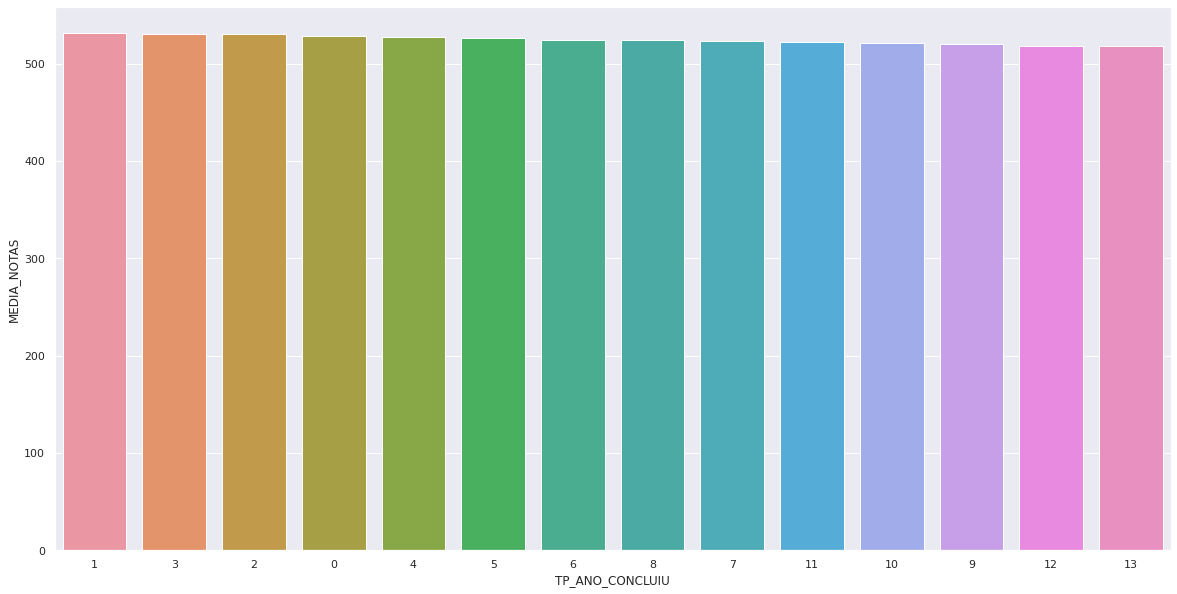

In [148]:
aux = df3[['TP_ANO_CONCLUIU', 'MEDIA_NOTAS']].groupby('TP_ANO_CONCLUIU').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()
print(aux)
sns.barplot(x='TP_ANO_CONCLUIU', y='MEDIA_NOTAS', data=aux, order=aux['TP_ANO_CONCLUIU']);


**5.2.6 Alunos de escolas particulares tem notas mais altas**

   TP_ESCOLA  MEDIA_NOTAS
0          3   605.318211
1          1   527.699538
2          2   510.642354


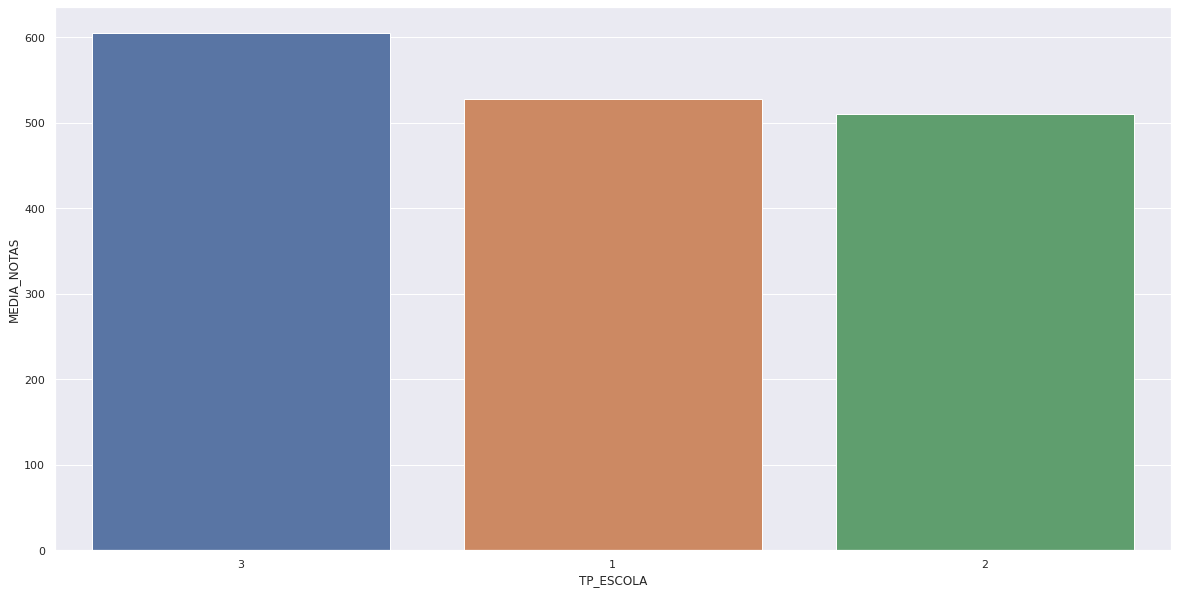

In [149]:
aux = df3[['TP_ESCOLA', 'MEDIA_NOTAS']].groupby('TP_ESCOLA').mean().sort_values('MEDIA_NOTAS', ascending=False).reset_index()
print(aux)
sns.barplot(x='TP_ESCOLA', y='MEDIA_NOTAS', data=aux, order=aux['TP_ESCOLA']);
#1: Não Respondeu
#2:Pública
#3:Privada